## Data Cleaning And EDA

In [361]:
import pandas as pd
import numpy as np

CSV_PATH = r"public/files/raw_vertigo_survey_form_responses.csv"
df = pd.read_csv(CSV_PATH)

In [362]:
def clean_dataset(df):
    df = df.copy()

    # Clean column names
    df.columns = (
        df.columns.astype(str)
        .str.replace(r"\s+", " ", regex=True)
        .str.replace("\n", " ")
        .str.strip()
    )

    question_cols = df.columns[9:28]

    # Normalize Likert strings
    df[question_cols] = df[question_cols].apply(
        lambda s: s.str.strip().str.replace("  ", " ")
    )

    # Fix typos
    df[question_cols] = df[question_cols].replace({
        "3- quiet a": "3- quiet a lot",
        "3- quiet a ": "3- quiet a lot",
    })

    # Standardize NT
    df[question_cols] = df[question_cols].replace(
        {"NT": "N.T.", "n.t.": "N.T."}
    )

    # Fix earphone hour typo
    earphone_col = "IF YES THEN FOR HOW MANY HOURS?"
    if earphone_col in df.columns:
        df[earphone_col] = df[earphone_col].replace({"4-6 hours4": "4-6 hours"})

    # Job role cleaning
    if "JOB ROLE" in df.columns:
        df["JOB ROLE"] = df["JOB ROLE"].str.strip().str.title()

    return df, question_cols


In [363]:
def quick_eda(df, question_cols):
    print("Shape:", df.shape)

    print("\nMissing values:")
    print(df.isna().sum().sort_values(ascending=False).head(10))

    print("\nSVQ distributions:")
    print()
    for col in question_cols:
        # print(col)
        print(df[col].value_counts().head())
        print()


In [364]:
clean_df, question_cols = clean_dataset(df)
quick_eda(clean_df, question_cols)


Shape: (115, 28)

Missing values:
JOB ROLE                                                     5
NAME                                                         0
GENDER                                                       0
AGE                                                          0
CONTACT NO./ EMAIL- ID                                       0
TYPICAL DAILY WORKING HOURS                                  0
HOW MANY HOURS DO YOU SPEND IN FRONT OF SCREEN DAILY?        0
DOES YOUR WORK INVOLVE USAGE OR EARPHONES/HEADPHONES         0
IF YES THEN FOR HOW MANY HOURS?                              0
1. Riding as a passenger in a car on straight, flat roads    0
dtype: int64

SVQ distributions:

1. Riding as a passenger in a car on straight, flat roads
1- very slightly    34
2- somewhat         31
0- not at all       30
3- quiet a lot      14
N.T.                 4
Name: count, dtype: int64

2. Riding as a passenger in a car on winding or bumpy roads.
2- somewhat         32
0- not at all     

## SVQ Scoring + Stacked Bar Chart

In [365]:
def convert_svq_numeric(df, question_cols):
    """
    Convert Likert responses to numeric 0–4.
    N.T. → NaN
    """
    svq_numeric = (
        df[question_cols]
        .replace("N.T.", np.nan)
        .apply(lambda s: s.str[0])  # first character = score
        .astype(float)
    )
    return svq_numeric



In [366]:
def compute_svq_scores(df, svq_numeric):
    """
    Adds:
    - SVQ_score (mean of items)
    - SVQ_severity category
    """
    df = df.copy()

    df["SVQ_score"] = svq_numeric.mean(axis=1)

    bins = [-np.inf, 1, 3, np.inf]
    labels = ["Minimal", "Moderate", "High"]

    df["SVQ_severity"] = pd.cut(df["SVQ_score"], bins=bins, labels=labels)

    return df


In [367]:
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_svq_stacked(svq_numeric, question_cols, save_path="output/svq_item_response_stacked_bar.png"):
    """
    Horizontal stacked % distribution plot for each SVQ item
    """

    levels = [0, 1, 2, 3, 4]

    percentage_df = (
        svq_numeric.apply(
            lambda col: col.value_counts(normalize=True)
            .reindex(levels, fill_value=0) * 100
        )
    ).T

    fig, ax = plt.subplots(figsize=(12, max(6, len(question_cols)*0.35)))

    left = np.zeros(len(percentage_df))

    for level in levels:
        values = percentage_df[level]
        ax.barh(percentage_df.index, values, left=left, edgecolor="white", label=str(level))
        left += values

    ax.set_xlim(0, 100)
    ax.set_xlabel("Percentage")
    ax.set_ylabel("SVQ Item")
    ax.set_yticklabels([f"Q{i+1}" for i in range(len(question_cols))])
    ax.legend(title="Response")

    plt.tight_layout()

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

    print(f"✓ Saved plot → {save_path}")


/tmp/ipykernel_16532/2646257592.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"Q{i+1}" for i in range(len(question_cols))])


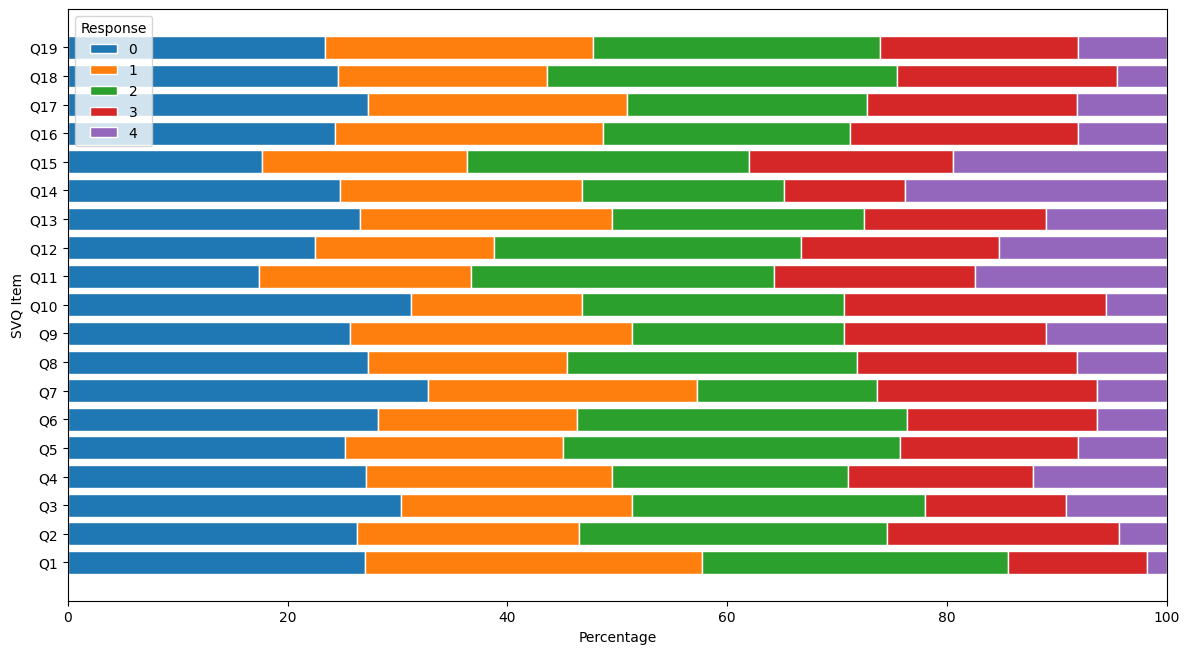

✓ Saved plot → output/svq_item_response_stacked_bar.png


In [368]:
svq_numeric = convert_svq_numeric(clean_df, question_cols)

clean_df = compute_svq_scores(clean_df, svq_numeric)

plot_svq_stacked(svq_numeric, question_cols)


In [369]:
clean_df[["SVQ_score", "SVQ_severity"]].head()

,SVQ_score,SVQ_severity
0,0.526316,Minimal
1,0.000000,Minimal
2,1.894737,Moderate
3,0.352941,Minimal
4,0.000000,Minimal


## Statistical Inference - Prevalence Calculation and Pie Chart Visualisation

In [370]:
from statsmodels.stats.proportion import proportion_confint

def calculate_prevalence(df, severity_col="SVQ_severity"):
    """
    Returns:
    - counts table
    - prevalence %
    - 95% confidence interval
    """

    counts = df[severity_col].value_counts()

    minimal = counts.get("Minimal", 0)
    moderate = counts.get("Moderate", 0)
    high = counts.get("High", 0)

    total = minimal + moderate + high
    symptomatic = moderate + high

    prevalence = symptomatic / total

    ci_low, ci_high = proportion_confint(symptomatic, total, method="wilson")

    summary = pd.DataFrame({
        "n": [minimal, moderate, high, symptomatic],
        "%": [
            minimal/total*100,
            moderate/total*100,
            high/total*100,
            prevalence*100
        ]
    },
    index=["Minimal", "Moderate", "High", "Symptomatic"])

    return summary, prevalence*100, ci_low*100, ci_high*100


In [371]:
import matplotlib.pyplot as plt
import os

def plot_prevalence_pie(summary_table, save_path="output/svq_severity_pie_chart.png"):
    """
    Pie chart from summary table
    """

    values = summary_table.loc[["Minimal","Moderate","High"], "n"]
    labels = values.index

    fig, ax = plt.subplots(figsize=(6,6))
    ax.pie(values, labels=labels, autopct="%1.1f%%", startangle=90)
    ax.axis("equal")

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

    print(f"✓ Saved → {save_path}")


              n          %
Minimal      36  31.578947
Moderate     68  59.649123
High         10   8.771930
Symptomatic  78  68.421053

Prevalence = 68.42%
95% CI = 59.41% – 76.23%


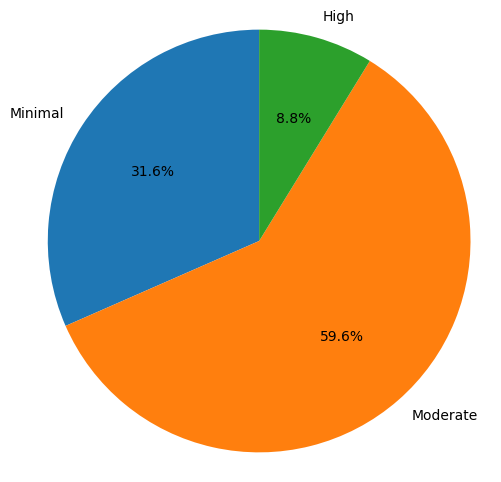

✓ Saved → output/svq_severity_pie_chart.png


In [372]:
summary_table, prevalence, ci_low, ci_high = calculate_prevalence(clean_df)

print(summary_table)

print(f"\nPrevalence = {prevalence:.2f}%")
print(f"95% CI = {ci_low:.2f}% – {ci_high:.2f}%")

plot_prevalence_pie(summary_table)


In [373]:
def prepare_numeric_columns(df):
    df = df.copy()

    # Replace AGE directly
    df["AGE"] = (
        df["AGE"]
        .astype(str)
        .str.extract(r'(\d+)')[0]
        .astype(float)
    )

    screen_map = {
        "> 8 hours": 8.5,
        "6-8 hours": 7,
        "4-6 hours": 5,
        "<4 hours": 2,
    }

    earphone_map = {
        "<4 hours": 2,
        "4-6 hours": 5,
        "6-8 hours": 7,
        ">8hours": 8.5,
    }

    df["Screen_hours"] = df["HOW MANY HOURS DO YOU SPEND IN FRONT OF SCREEN DAILY?"].map(screen_map)
    df["Earphone_hours"] = df["IF YES THEN FOR HOW MANY HOURS?"].map(earphone_map)

    return df


In [374]:
# Ensure derived numeric columns exist on clean_df
clean_df = prepare_numeric_columns(clean_df)


In [375]:
def summarize_continuous(series):
    mean_sd = f"{series.mean():.2f} ± {series.std():.2f}"
    median_iqr = f"{series.median():.2f} ({series.quantile(0.25):.2f}–{series.quantile(0.75):.2f})"
    min_max = f"{series.min():.2f}–{series.max():.2f}"

    return mean_sd, median_iqr, min_max


In [376]:
def build_descriptive_table(df):
    N = len(df)
    rows = []

    # Continuous variables
    for label, col in [
        ("Age (years)", "AGE"),
        ("Screen Time (hours/day)", "Screen_hours"),
        ("Earphone Usage (hours/day)", "Earphone_hours"),
        ("Total SVQ Score", "SVQ_score"),
    ]:
        mean_sd, median_iqr, min_max = summarize_continuous(df[col])
        rows.append([label, mean_sd, median_iqr, min_max])

    # Helper for categorical
    def add_categorical(title, column):
        rows.append(["", "", "", ""])
        rows.append([title, "", "", ""])

        counts = df[column].value_counts()

        for k, v in counts.items():
            rows.append([
                f"  {k}",
                f"{v} ({v/N*100:.2f}%)",
                "",
                ""
            ])

    add_categorical("Gender", "GENDER")
    add_categorical("Job Role", "JOB ROLE")
    add_categorical("SVQ Symptom Status", "SVQ_severity")

    return pd.DataFrame(
        rows,
        columns=["Variable", "Mean ± SD / n (%)", "Median (IQR)", "Min–Max"]
    )


In [377]:
import matplotlib.pyplot as plt
import os

def export_table_image(table_df, filename="Table1_descriptive_statistics"):
    os.makedirs("output", exist_ok=True)

    fig, ax = plt.subplots(figsize=(9, len(table_df)*0.35))
    ax.axis("off")

    table = ax.table(
        cellText=table_df.values,
        colLabels=table_df.columns,
        cellLoc="left",
        loc="center"
    )

    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.4)

    img_path = f"output/{filename}.png"
    csv_path = f"output/{filename}.csv"

    plt.savefig(img_path, dpi=300, bbox_inches="tight")
    table_df.to_csv(csv_path, index=False)

    plt.close()

    print(f"✓ Saved → {img_path}")
    print(f"✓ Saved → {csv_path}")


In [378]:
def export_describe_table(df, filename="Table2_describe_statistics"):
    numeric_cols = ["AGE", "Screen_hours", "Earphone_hours", "SVQ_score"]

    desc = df[numeric_cols].describe().T.round(2)

    os.makedirs("output", exist_ok=True)

    desc.to_csv(f"output/{filename}.csv")

    print(f"✓ Saved → output/{filename}.csv")

    return desc


In [379]:
table1_df = clean_df[clean_df["SVQ_severity"].notna()]
table1_df = prepare_numeric_columns(table1_df)

table_df = build_descriptive_table(table1_df)
export_table_image(table_df, "Table1_descriptive_statistics")
export_describe_table(table1_df)


✓ Saved → output/Table1_descriptive_statistics.png
✓ Saved → output/Table1_descriptive_statistics.csv
✓ Saved → output/Table2_describe_statistics.csv


,count,mean,std,min,25%,50%,75%,max
AGE,114.0,23.60,5.97,20.0,20.00,20.00,30.00,40.0
Screen_hours,114.0,6.97,1.49,2.0,5.00,7.00,8.50,8.5
Earphone_hours,114.0,4.65,2.20,2.0,2.00,5.00,7.00,8.5
SVQ_score,114.0,1.63,1.02,0.0,0.74,1.74,2.37,4.0


## Descriptive Visualisations

In [380]:
import matplotlib.pyplot as plt
import os

def plot_age_distribution(df, save_path="output/age_group_distribution.png"):
    """
    Bar chart of age group counts
    """

    counts = df["AGE"].value_counts().sort_index()
    total = counts.sum()

    fig, ax = plt.subplots(figsize=(7,5))

    ax.bar(counts.index.astype(str), counts.values)

    for i, v in enumerate(counts.values):
        pct = v/total*100
        ax.text(i, v, f"{v}\n({pct:.1f}%)", ha="center", va="bottom")

    ax.set_xlabel("Age Group")
    ax.set_ylabel("Count")
    ax.set_title(f"Age Distribution (N = {total})")

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.close()

    print(f"✓ Saved → {save_path}")


In [381]:
def plot_severity_distribution(df, save_path="output/severity_distribution.png"):
    """
    Bar chart of SVQ severity distribution
    """

    counts = df["SVQ_severity"].value_counts()
    total = counts.sum()

    fig, ax = plt.subplots(figsize=(7,5))

    ax.bar(counts.index.astype(str), counts.values)

    for i, v in enumerate(counts.values):
        pct = v/total*100
        ax.text(i, v, f"{v}\n({pct:.1f}%)", ha="center", va="bottom")

    ax.set_xlabel("Severity")
    ax.set_ylabel("Count")
    ax.set_title(f"SVQ Severity Distribution (N = {total})")

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.close()

    print(f"✓ Saved → {save_path}")


In [382]:
plot_age_distribution(clean_df)
plot_severity_distribution(clean_df)

✓ Saved → output/age_group_distribution.png
✓ Saved → output/severity_distribution.png


## Normality + correlation

In [383]:
def create_analysis_dataset(clean_df):
    """
    Creates analysis dataset by removing participants
    with missing SVQ score (primary outcome missing)
    """
    analysis_df = clean_df[clean_df["SVQ_score"].notna()].copy()

    print(f"Total cleaned participants : {len(clean_df)}")
    print(f"Included in analysis      : {len(analysis_df)}")
    print(f"Excluded (missing SVQ)    : {len(clean_df) - len(analysis_df)}")

    return analysis_df


In [384]:
analysis_df = create_analysis_dataset(clean_df)

Total cleaned participants : 115
Included in analysis      : 114
Excluded (missing SVQ)    : 1


In [385]:
from scipy import stats
import pandas as pd
import os

def run_normality_tests(df):
    cols = ["Screen_hours", "Earphone_hours", "SVQ_score"]

    rows = []

    for col in cols:
        stat, p = stats.shapiro(df[col].dropna())

        rows.append([
            col,
            round(stat, 4),
            round(p, 4),
            "Normal" if p > 0.05 else "Non-normal"
        ])

    normality_df = pd.DataFrame(
        rows,
        columns=["Variable", "W-statistic", "p-value", "Distribution"]
    )

    os.makedirs("output", exist_ok=True)
    normality_df.to_csv("output/normality_results.csv", index=False)

    return normality_df


In [386]:
def run_correlation_tests(df):

    pairs = [
        ("Screen_hours", "SVQ_score", "Screen Time vs SVQ"),
        ("Earphone_hours", "SVQ_score", "Earphone Usage vs SVQ")
    ]

    rows = []

    for x, y, label in pairs:

        data = df[[x, y]].dropna()

        # choose Spearman (safe for non-normal questionnaire data)
        r, p = stats.spearmanr(data[x], data[y])

        rows.append([
            label,
            "Spearman",
            round(r, 4),
            round(p, 4),
            len(data)
        ])

    corr_df = pd.DataFrame(
        rows,
        columns=["Variables", "Method", "r", "p-value", "N"]
    )

    corr_df.to_csv("output/correlation_results.csv", index=False)

    return corr_df


In [387]:
def export_correlation_matrix(df):

    cols = ["Screen_hours", "Earphone_hours", "SVQ_score"]

    matrix = df[cols].corr(method="spearman").round(3)

    matrix.to_csv("output/correlation_matrix.csv")

    return matrix



In [388]:
normality_df = run_normality_tests(analysis_df)
correlation_df = run_correlation_tests(analysis_df)
corr_matrix = export_correlation_matrix(analysis_df)

print("Normality Tests:")
print(normality_df)
print()

print("Correlation Tests:")
print(correlation_df)
print()

print("Correlation Matrix:")
print(corr_matrix)
print()

print("\nAll results saved to output/ directory.")


Normality Tests:
         Variable  W-statistic  p-value Distribution
0    Screen_hours       0.8011   0.0000   Non-normal
1  Earphone_hours       0.8383   0.0000   Non-normal
2       SVQ_score       0.9676   0.0073   Non-normal

Correlation Tests:
               Variables    Method       r  p-value    N
0     Screen Time vs SVQ  Spearman -0.1564   0.0965  114
1  Earphone Usage vs SVQ  Spearman  0.4133   0.0000  114

Correlation Matrix:
                Screen_hours  Earphone_hours  SVQ_score
Screen_hours           1.000           0.122     -0.156
Earphone_hours         0.122           1.000      0.413
SVQ_score             -0.156           0.413      1.000


All results saved to output/ directory.


## Group Comparison

In [389]:
from scipy import stats
import pandas as pd
import os

def gender_comparison(df):

    groups = df.groupby("GENDER")["SVQ_score"]

    names = list(groups.groups.keys())

    if len(names) != 2:
        return None

    g1 = groups.get_group(names[0])
    g2 = groups.get_group(names[1])

    u, p = stats.mannwhitneyu(g1, g2)

    return {
        "Comparison": "Gender vs SVQ",
        "Test": "Mann–Whitney U",
        "Statistic": round(u, 3),
        "p-value": round(p, 4),
        "N": len(g1) + len(g2)
    }


In [390]:
def jobrole_comparison(df, min_n=10):

    grouped = df.groupby("JOB ROLE")["SVQ_score"]

    valid = [g for g in grouped if len(g[1]) >= min_n]

    if len(valid) < 2:
        return None

    groups_data = [g[1] for g in valid]

    h, p = stats.kruskal(*groups_data)

    return {
        "Comparison": "Job Role vs SVQ",
        "Test": "Kruskal–Wallis H",
        "Statistic": round(h, 3),
        "p-value": round(p, 4),
        "N": sum(len(g[1]) for g in valid)
    }


In [391]:
def run_group_comparisons(df):

    results = []

    g = gender_comparison(df)
    j = jobrole_comparison(df)

    if g: results.append(g)
    if j: results.append(j)

    summary_df = pd.DataFrame(results)

    os.makedirs("output", exist_ok=True)
    summary_df.to_csv("output/group_comparison_results.csv", index=False)

    return summary_df


In [392]:
group_results = run_group_comparisons(analysis_df)

print(group_results)


        Comparison              Test  Statistic  p-value    N
0    Gender vs SVQ    Mann–Whitney U   2049.500   0.0129  114
1  Job Role vs SVQ  Kruskal–Wallis H      0.016   0.9923   51


In [393]:
import matplotlib.pyplot as plt
import os

def plot_gender_boxplot(df, save_path="output/gender_svq_boxplot.png"):

    groups = df.groupby("GENDER")["SVQ_score"]

    labels = []
    data = []

    for name, scores in groups:
        labels.append(name)
        data.append(scores)

    fig, ax = plt.subplots(figsize=(6,5))

    ax.boxplot(data, labels=labels, showmeans=True)

    ax.set_xlabel("Gender")
    ax.set_ylabel("SVQ Score")
    ax.set_title("SVQ Score by Gender")

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.close()

    print(f"✓ Saved → {save_path}")


In [394]:
plot_gender_boxplot(analysis_df)


✓ Saved → output/gender_svq_boxplot.png


/tmp/ipykernel_16532/52219234.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showmeans=True)


In [395]:
import os

def save_processed_data(df, filename="vertigo_survey_processed.csv", output_dir="output"):
    """
    Save cleaned + processed dataset to CSV.
    Ensures Screen_hours and Earphone_hours are present.
    """
    df = df.copy()

    required_cols = {"Screen_hours", "Earphone_hours"}
    if not required_cols.issubset(df.columns):
        df = prepare_numeric_columns(df)

    missing = required_cols.difference(df.columns)
    if missing:
        raise ValueError(f"Missing required columns after preparation: {sorted(missing)}")

    os.makedirs(output_dir, exist_ok=True)

    path = os.path.join(output_dir, filename)
    df.to_csv(path, index=False)

    print("\n" + "="*40)
    print("FINAL DATASET EXPORTED")
    print("="*40)
    print(f"Path: {path}")
    print(f"Rows: {df.shape[0]}")
    print(f"Columns: {df.shape[1]}")
    print("="*40)

    return path


In [396]:
processed_path = save_processed_data(clean_df)


FINAL DATASET EXPORTED
Path: output/vertigo_survey_processed.csv
Rows: 115
Columns: 32
